In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import numpy.random as rng
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from numpy.linalg import eig
from torch.autograd.functional import jacobian
from torch.optim.lr_scheduler import ReduceLROnPlateau

ModuleNotFoundError: No module named 'torch'

# Data generation

In [2]:
def generate_initial_states_and_inputs(n_hidden, n_inputs,
                                       n_inits_per_state_dim=3,
                                       min_val_per_state_dim=-1.0,
                                       max_val_per_state_dim=1.0,
                                       debug=False):
    '''Generates a grid of initial states and zeroed-out inputs in a format
    compatible with RNNCell.
    Args:
        n_hidden:
            Non-negative int specifying the number of hidden units in the RNN.
        n_inputs:
            Non-negative int specifying the number of inputs to the RNN.
            Inputs are ignored by these test RNN's, so this value can be set
            arbitrarily without affecting results. This is included only to
            ensure input dimensionality is consistent across the various
            objects used in a test.
        n_inits_per_state_dim (optional):
            Non-negative int specifying the grid resolution for each
            dimension. The total number of grid states will be
            pow(n_inits_per_state_dim, n_hidden). Default: 3.
        min_val_per_state_dim (optional):
            Float specifying the minimum value for each state dimension.
            Default: -1.0.
        max_val_per_state_dim (optional):
            Float specifying the maximum value for each state dimension.
            Default: 1.0.
        debug (optional):
            Bool indicating whether to visualize the grid of states for the
            first two state dimensions (first two hidden units). Default:
            False.
    Returns:
        grid_states:
            [n, n_hidden] numpy array with grid_states[i, :] representing one
            initial state.
        inputs:
            [1, n_inputs] numpy array of zeros.
    '''

    # All inputs are set to zero.
    inputs = np.zeros([1,n_inputs])

    grid_coords_1D = (np.linspace(min_val_per_state_dim, max_val_per_state_dim, n_inits_per_state_dim) for hidden_idx in range(n_hidden))
    grid_states_list = np.meshgrid(*grid_coords_1D)

    n_inits = pow(n_inits_per_state_dim, n_hidden)
    grid_states = np.transpose(
        np.reshape(np.array(grid_states_list), [n_hidden, n_inits]))

    # Visualize the grid of initial states (first 2 dims only)
    if debug and n_hidden > 1:
        import matplotlib.pyplot as plt
        plt.figure()
        for state_idx in range(n_inits):
            plt.plot(grid_states[state_idx, 0],
                     grid_states[state_idx, 1],
                     'rx')
        plt.show()

    return grid_states, inputs


def generate_data(data_hps, train_or_valid_str=None):
    '''Generates synthetic data (i.e., ground truth trials) for the
    FlipFlop task. See comments following FlipFlop class definition for a
    description of the input-output relationship in the task.
    Args:
        None (RecurrentWhisperer option train_or_valid_str is ignored).
    Returns:
        dict containing 'inputs' and 'outputs'.
            'inputs': [n_batch x n_time x n_bits] numpy array containing
            input pulses.
            'outputs': [n_batch x n_time x n_bits] numpy array specifying
            the correct behavior of the FlipFlop memory device.
    '''

    # data_hps = self.hps.data_hps
    n_batch = data_hps['n_batch']
    n_time = data_hps['n_time']
    n_bits = data_hps['n_bits']
    p_flip = data_hps['p_flip']

    # Randomly generate unsigned input pulses
    unsigned_inputs = rng.binomial(
        1, p_flip, [n_batch, n_time, n_bits])

    # Ensure every trial is initialized with a pulse at time 0
    unsigned_inputs[:, 0, :] = 1

    # Generate random signs {-1, +1}
    random_signs = 2*rng.binomial(
        1, 0.5, [n_batch, n_time, n_bits]) - 1

    # Apply random signs to input pulses
    inputs = np.multiply(unsigned_inputs, random_signs)

    # Allocate output
    output = np.zeros([n_batch, n_time, n_bits])

    # Update inputs (zero-out random start holds) & compute output
    for trial_idx in range(n_batch):
        for bit_idx in range(n_bits):
            input_ = np.squeeze(inputs[trial_idx, :, bit_idx])
            t_flip = np.where(input_ != 0)
            for flip_idx in range(np.size(t_flip)):
                # Get the time of the next flip
                t_flip_i = t_flip[0][flip_idx]

                '''Set the output to the sign of the flip for the
                remainder of the trial. Future flips will overwrite future
                output'''
                output[trial_idx, t_flip_i:, bit_idx] = \
                    inputs[trial_idx, t_flip_i, bit_idx]

    return {'inputs': inputs, 'output': output}

In [48]:
inputs.size

98304

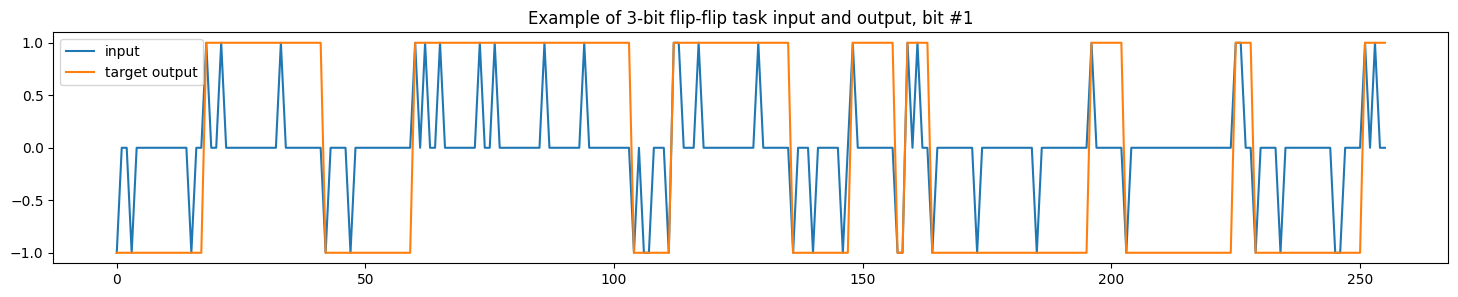

In [109]:
fig, axes = plt.subplots(1, 1, figsize=(18, 3), sharex=True)

axes.plot(inputs[0, :, 0], label='input')
axes.plot(labels[0, :, 0], label='target output')
axes.set_title('Example of 3-bit flip-flip task input and output, bit #1')
axes.set_
axes.legend()


Text(0.5, 0.98, 'Example of 3-bit flip-flip task input and output')

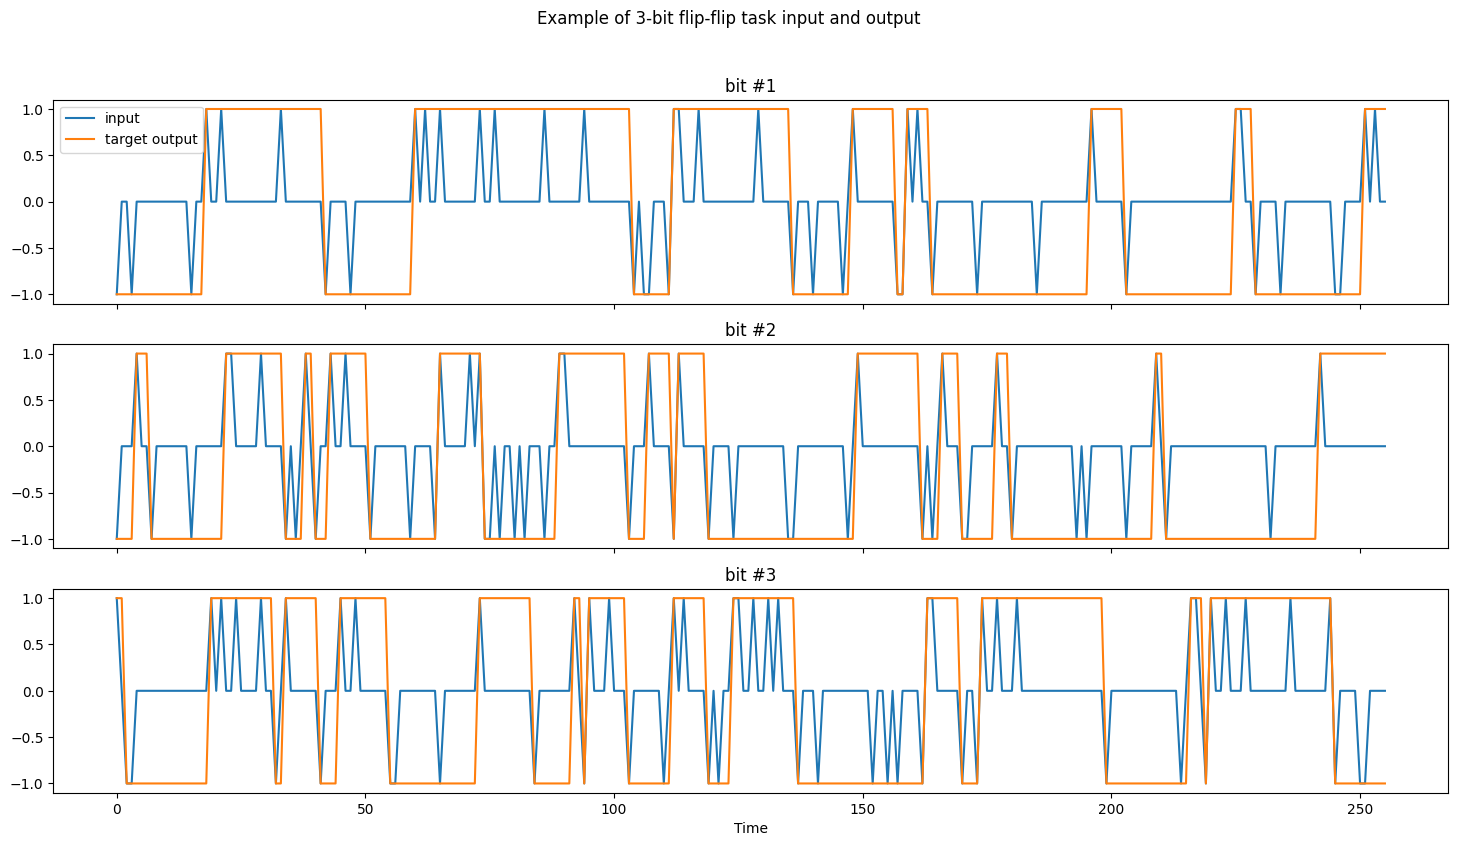

In [47]:
data_hps = {
    'n_batch': 128,
    'n_time': 256,
    'n_bits': 3,
    'p_flip': 0.2}
generated_data = generate_data(data_hps)

inputs = generated_data['inputs']
labels = generated_data['output']

fig, axes = plt.subplots(3, 1, figsize=(18, 9), sharex=True)
# axes[0].figure(figsize=(18, 3))
axes[0].plot(inputs[0, :, 0], label='input')
axes[0].plot(labels[0, :, 0], label='target output')
axes[0].set_title('bit #1')
axes[0].legend()

axes[1].plot(inputs[1, :, 1], label='input')
axes[1].plot(labels[1, :, 1], label='target output')
axes[1].set_title('bit #2')
# axes[1].legend()

axes[2].plot(inputs[2, :, 2], label='input')
axes[2].plot(labels[2, :, 2], label='target output')
axes[2].set_title('bit #3')
axes[2].set_xlabel('Time')
# axes[2].legend()


fig.suptitle('Example of 3-bit flip-flip task input and output')

# Model and dataloader building, training

In [50]:
inputs = torch.from_numpy(generated_data['inputs']).float()
labels = torch.from_numpy(generated_data['output']).float()

print(inputs.type())
print(inputs.shape)
print(labels.type())
print(labels.shape)

torch.FloatTensor
torch.Size([128, 256, 3])
torch.FloatTensor
torch.Size([128, 256, 3])


In [5]:
class RNN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, nonlinearity='tanh'):
        super().__init__()
        self.rnn = nn.RNN(in_size, hidden_size, batch_first=True, nonlinearity=nonlinearity)
        self.decoder = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        # print(rnn_out.shape)
        batch_size, T, _ = rnn_out.shape
        rnn_out_reshaped = rnn_out.reshape(batch_size*T, -1)
        decoder_out = self.decoder(rnn_out_reshaped)
        # print(decoder_out.reshape(batch_size, T, -1).shape)
        return decoder_out.reshape(batch_size, T, -1), rnn_out
    

class MyDataset(Dataset):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.inputs = inputs
        self.outputs = outputs
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    

def training(loader, model, optimizer, loss_fn, clip_thr=1, epochs=10000, disp_freq=100): 
    loss_list = [] # contains average loss at each epoch
    gradient_list = []
    for ie in range(epochs):
        loss_sum = 0
        gradient_sum = 0
        for batch_idx, batch in enumerate(loader):
            ins, tgt = batch
            output= optimizer.zero_grad()
            # if batch_idx == 0:
            #     print(ins)
            output, _ = model(ins)
            loss = loss_fn(output, tgt)
            curr_loss = loss.item()
            loss_sum = loss_sum + curr_loss
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), clip_thr)
            curr_gradient = np.mean([p.grad.norm() for p in model.parameters()])
            gradient_sum = gradient_sum + curr_gradient
            optimizer.step()
        gradient_list.append(gradient_sum)
        loss_list.append(loss_sum)

        if ie % disp_freq == 0:
            print('epoch: ', ie)
            print('average loss: ', loss_sum)
            print('average gradient: ', gradient_sum)
    return loss_list, gradient_list

In [6]:
model = RNN(data_hps['n_bits'], 32, data_hps['n_bits'])
optimizer = optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()
dataset = MyDataset(inputs, labels)
loader = DataLoader(dataset, batch_size=128, num_workers=0)

loss_list, gradient_list = training(loader, model, optimizer, loss_fn, epochs=500, disp_freq=100)

epoch:  0
average loss:  1.0507274866104126
average gradient:  0.1766776442527771
epoch:  100
average loss:  0.10042792558670044
average gradient:  0.013103384524583817
epoch:  200
average loss:  0.008203134872019291
average gradient:  0.0035006674006581306
epoch:  300
average loss:  0.001510322093963623
average gradient:  0.000929968839045614
epoch:  400
average loss:  0.0007590853492729366
average gradient:  0.0008653478580527008


# model test with nonempty input

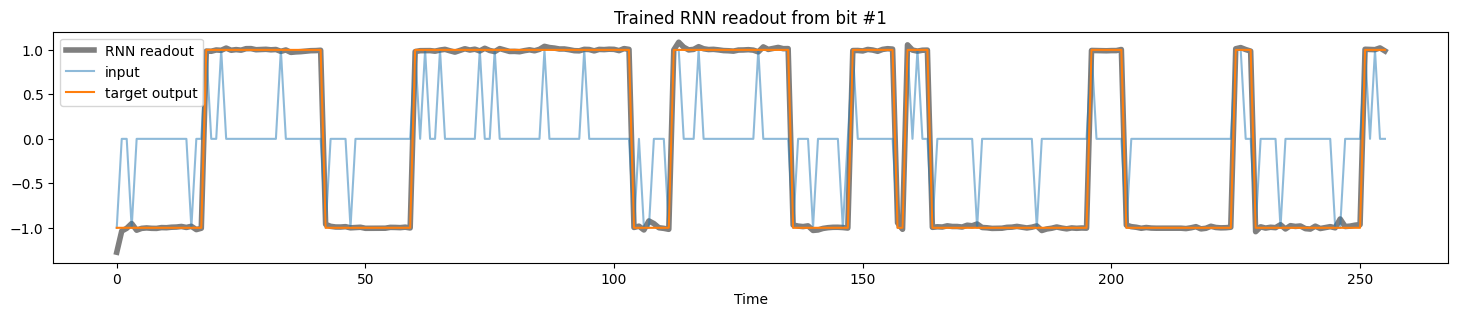

In [57]:
with torch.no_grad():
    modelout, _ = model.forward(inputs[0].unsqueeze(dim=0))
    modelout = modelout.detach() 
    fig, axes = plt.subplots(1, 1, figsize=(18, 3), sharex=True)
    
    axes.plot(modelout.squeeze()[:, 0], 'C7', linewidth=4, label='RNN readout')
    axes.plot(inputs[0].squeeze()[:, 0], 'C0', label='input', alpha=0.5)
    axes.plot(labels[0, :, :].squeeze()[:, 0], 'C1', label='target output')
    axes.set_title('Trained RNN readout from bit #1')
    axes.set_xlabel('Time')

    axes.legend()


In [61]:
modelout.squeeze().shape

torch.Size([256, 3])

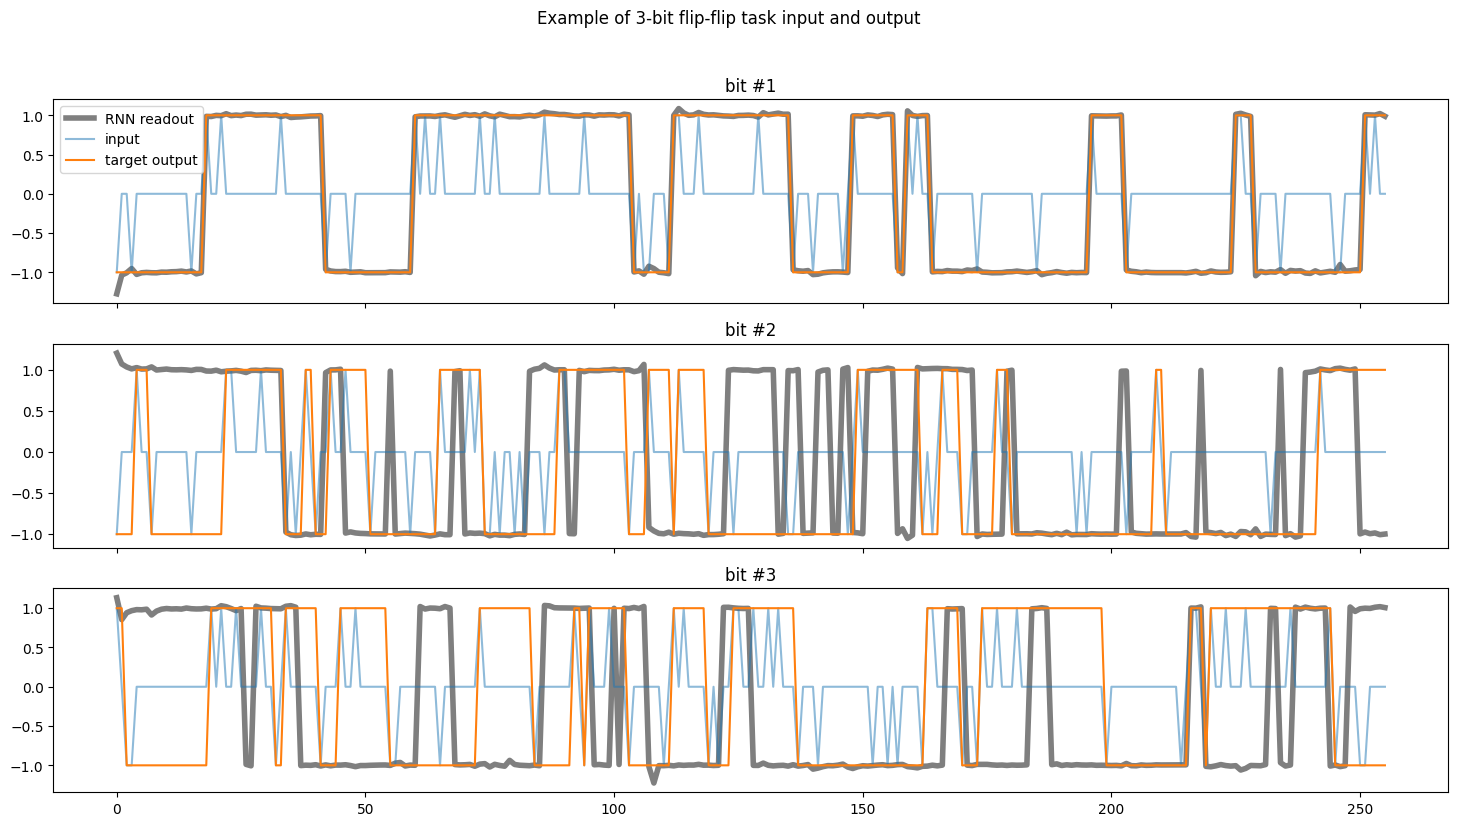

In [51]:
with torch.no_grad():
    modelout, _ = model.forward(inputs[0].unsqueeze(dim=0))
    modelout = modelout.detach() 
    fig, axes = plt.subplots(3, 1, figsize=(18, 9), sharex=True)
    
    axes[0].plot(modelout.squeeze()[:, 0], 'C7', linewidth=4, label='RNN readout')
    axes[0].plot(inputs[0].squeeze()[:, 0], 'C0', label='input', alpha=0.5)
    axes[0].plot(labels[0, :, :].squeeze()[:, 0], 'C1', label='target output')
    axes[0].set_title('bit #1')
    axes[0].legend()

    axes[1].plot(modelout.squeeze()[:, 1], 'C7', linewidth=4, label='RNN readout')
    axes[1].plot(inputs[1].squeeze()[:, 1], 'C0', label='input', alpha=0.5)
    axes[1].plot(labels[1, :, :].squeeze()[:, 1], 'C1', label='target output')
    axes[1].set_title('bit #2')

    axes[2].plot(modelout.squeeze()[:, 2], 'C7', linewidth=4, label='RNN readout')
    axes[2].plot(inputs[2].squeeze()[:, 2], 'C0', label='input', alpha=0.5)
    axes[2].plot(labels[2, :, :].squeeze()[:, 2], 'C1', label='target output')
    axes[2].set_title('bit #3')

    fig.suptitle('Example of 3-bit flip-flip task input and output')


In [8]:
model.eval()
with torch.no_grad():
    modelout, hiddens = model.forward(inputs)
    # modelout = modelout.detach() 
    # plt.plot(modelout.squeeze()[:, 0], label='RNN readout')
    # plt.plot(inputs[0].squeeze()[:, 0], label='input')
    # plt.plot(labels[0, :, :].squeeze()[:, 0], label='target output')

    # plt.legend()
    # plt.show()


(32768, 3)


Text(0.5, 0, 'PC3')

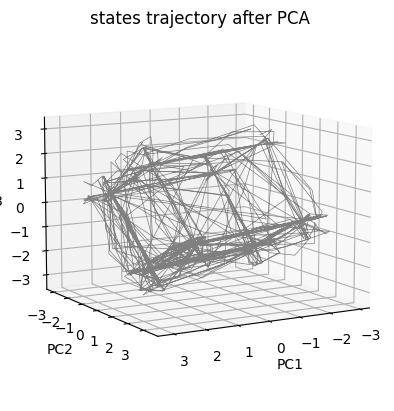

In [104]:
hiddens = hiddens.reshape(-1, 32)
hiddens = hiddens.squeeze().detach()
pca = PCA(n_components = 3)
hiddens_pca = pca.fit_transform(hiddens)
hiddens_pca = pca.transform(hiddens)

print(hiddens_pca.shape)

ax = plt.axes(projection='3d')
ax.plot3D(hiddens_pca[:1000, 0], hiddens_pca[:1000, 1], hiddens_pca[:1000, 2], linewidth=0.5, color='gray')
ax.view_init(10, 60, 0)

ax.set_title('states trajectory after PCA')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


# run on [0] input 

In [10]:
# import imageio

# def create_frame(t, x, hiddens_pca):

#     fig = plt.figure()
#     ax = plt.axes(projection='3d')

#     x_pca = pca.transform(x.requires_grad_(False))
#     # ax = plt.axes(projection='3d')
#     ax.plot3D(hiddens_pca[:1500, 0], hiddens_pca[:1500, 1], hiddens_pca[:1500, 2], linewidth=0.5)
#     ax.scatter3D(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], color='red')
#     # ax.view_init(20, 60, 0)

#     fig.savefig(f'./img/img_{t}.png', 
#                 transparent = False,  
#                 facecolor = 'white'
#                )
#     plt.close()


# frames = []
# for t in it:
#     image = imageio.v2.imread(f'./img/img_{t}.png')
#     frames.append(image)
# imageio.mimsave('./example.gif', # output gif
#                 frames,          # array of input frames
#                 fps = 30000)         # optional: frames per second

In [88]:
init_states = hiddens[np.random.choice(np.arange(30000), 500), :] + torch.normal(torch.zeros([500, 32]), torch.ones([500, 32])) # random sample from all hidden state trajectories
init_states = torch.Tensor(init_states.numpy()).requires_grad_()
print(init_states)
print(init_states.shape)

tensor([[-0.0646, -1.1227, -0.9487,  ...,  0.1512, -0.9086,  0.6798],
        [ 1.9696, -0.5325, -0.9261,  ..., -1.0001,  0.2353, -0.7087],
        [ 1.9221, -0.8420, -0.6649,  ..., -0.2904, -0.5350,  0.0980],
        ...,
        [ 0.4586,  1.3926,  1.8299,  ..., -0.5924,  0.3049, -1.1210],
        [-0.9777,  1.3786, -0.8422,  ..., -0.3379, -0.6023, -0.6757],
        [-0.2280,  1.0340, -1.3564,  ..., -0.3518,  2.0969,  0.8403]],
       requires_grad=True)
torch.Size([500, 32])


In [12]:
# # Define the function to optimize
# def function_to_optimize(x):

#     # hiddens = [model.rnn(torch.zeros([1, 1, 3]), x[idx, :].unsqueeze(dim=0).unsqueeze(dim=0))[1].squeeze(dim=0) for idx in np.arange(x.shape[0])]
#     # hiddens = torch.cat(hiddens, dim=0)

#     # print(x.shape)
#     hiddens = model.rnn(torch.zeros([100, 1, 3], requires_grad=False), x.unsqueeze(dim=0))[1].squeeze(dim=0)
#     # hiddens = model.rnn(torch.ones([500, 1, 3], requires_grad=False), x.unsqueeze(dim=0))[1].squeeze(dim=0)

#     return 0.5*torch.sum(torch.square(hiddens - x))

# # Define the initial value of x
# states_tensor = torch.tensor(init_states, requires_grad=True)
# for param in model.parameters():
#     param.requires_grad = False

# # Define the Adam optimizer
# optimizer = optim.Adam([states_tensor], eps=0.5)
# scheduler = ReduceLROnPlateau(optimizer, verbose=True)
# states_tensor.requires_grad_(True)
# for param in model.parameters():
#     print(param.requires_grad, 'needs to be False')
# print(states_tensor.requires_grad, 'needs to be True')


# # Optimization loop
# i = 0
# loss = 1

# # it = list()
# # create_frame(i, x, hiddens_pca)
# # it.append(i)

# bstates_tensor = states_tensor.reshape([5, 100, 32])
# print(bstates_tensor)

# while loss > 1e-5:
    
#     run_loss = 0
#     for bidx in range(5):
        
#         istates_tensor = torch.tensor(bstates_tensor[bidx, :, :].squeeze(), requires_grad=True)

#         # Evaluate the function at the current value of x
#         y = function_to_optimize(bstates_tensor)
        
#         # Compute the gradient of the function with respect to x
#         y.backward()
        
#         # Update the value of x using the Adam optimizer
#         optimizer.step()
        
#         # Zero out the gradients for the next iteration
#         optimizer.zero_grad()
        
#         loss = y.item()
#         run_loss += run_loss

#     scheduler.step(run_loss)

#     if (i + 1) % 1e3 == 0:
#         print('iteration %.0f, loss %.4e' % (i+1, loss))

#     # if (i + 1) % 100 == 0:
#     #     create_frame(i, x, hiddens_pca)
#     #     x.requires_grad_(True)
#     #     it.append(i)
#     i = i+1


# print('iteration %.f, loss %.2g' % (i+1, loss))
    


False needs to be False
False needs to be False
False needs to be False
False needs to be False
False needs to be False
False needs to be False
True needs to be True
tensor([[[ 0.3519, -0.0334,  0.2106,  ..., -0.2499, -0.4701,  0.6772],
         [ 0.3840, -0.0829,  0.1791,  ..., -0.1116,  0.4785,  0.6566],
         [-0.6704,  0.0087, -0.1897,  ...,  0.3112,  0.5004, -0.6146],
         ...,
         [ 0.2764,  0.3278,  0.4304,  ...,  0.3629,  0.4930, -0.6729],
         [-0.7780, -0.7947, -0.1854,  ...,  0.1679,  0.6502,  0.6689],
         [ 0.3150,  0.3880,  0.3077,  ...,  0.2411, -0.4491, -0.6527]],

        [[-0.4251,  0.1184, -0.1723,  ...,  0.1963, -0.4455, -0.6148],
         [ 0.5209,  0.6967, -0.1458,  ..., -0.2475, -0.9524, -0.6448],
         [ 0.5303,  0.4537, -0.1666,  ..., -0.6113, -0.9544,  0.6589],
         ...,
         [ 0.2805,  0.3391,  0.1922,  ...,  0.5173,  0.5388, -0.7003],
         [ 0.0114, -0.2152, -0.2017,  ...,  0.1968,  0.4121, -0.6262],
         [-0.6545,  0.5

/var/folders/lt/9cqmjwc546zgk6ws3r_678r00000gn/T/ipykernel_15048/269915093.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_tensor = torch.tensor(init_states, requires_grad=True)
/var/folders/lt/9cqmjwc546zgk6ws3r_678r00000gn/T/ipykernel_15048/269915093.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  istates_tensor = torch.tensor(bstates_tensor[bidx, :, :].squeeze(), requires_grad=True)


RuntimeError: For batched 3-D input, hx should also be 3-D but got 4-D tensor

In [94]:
# Define the function to optimize
def function_to_optimize(x):

    # hiddens = [model.rnn(torch.zeros([1, 1, 3]), x[idx, :].unsqueeze(dim=0).unsqueeze(dim=0))[1].squeeze(dim=0) for idx in np.arange(x.shape[0])]
    # hiddens = torch.cat(hiddens, dim=0)

    # print(x.shape)
    hiddens = model.rnn(torch.zeros([500, 1, 3], requires_grad=False), x.unsqueeze(dim=0))[1].squeeze(dim=0)
    # hiddens = model.rnn(torch.ones([500, 1, 3], requires_grad=False), x.unsqueeze(dim=0))[1].squeeze(dim=0)

    return 0.5*torch.sum(torch.square(hiddens - x))

# Define the initial value of x
states_tensor = torch.tensor(init_states, requires_grad=True)
for param in model.parameters():
    param.requires_grad = False

# Define the Adam optimizer
optimizer = optim.Adam([states_tensor], eps=0.5)
scheduler = ReduceLROnPlateau(optimizer, verbose=True)
states_tensor.requires_grad_(True)
for param in model.parameters():
    print(param.requires_grad, 'needs to be False')
print(states_tensor.requires_grad, 'needs to be True')


# Optimization loop
i = 0
loss = 1

# it = list()
# create_frame(i, x, hiddens_pca)
# it.append(i)

loss_list = []
while loss > 1e-7:
    

    # Evaluate the function at the current value of x
    y = function_to_optimize(states_tensor)
    
    # Compute the gradient of the function with respect to x
    y.backward()
    
    # Update the value of x using the Adam optimizer
    optimizer.step()
    
    # Zero out the gradients for the next iteration
    optimizer.zero_grad()
    
    loss = y.item()

    scheduler.step(loss)

    if (i + 1) % 1e3 == 0:
        print('iteration %.0f, loss %.4e' % (i+1, loss), end='\r')

    # if (i + 1) % 100 == 0:
    #     create_frame(i, x, hiddens_pca)
    #     x.requires_grad_(True)
    #     it.append(i)
    i = i+1
    loss_list.append(loss)

print()
print('COMPLETED iteration %.f, loss %.5g' % (i+1, loss))
    


/var/folders/lt/9cqmjwc546zgk6ws3r_678r00000gn/T/ipykernel_15048/61120747.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states_tensor = torch.tensor(init_states, requires_grad=True)


False needs to be False
False needs to be False
False needs to be False
False needs to be False
False needs to be False
False needs to be False
True needs to be True
Epoch 339020: reducing learning rate of group 0 to 1.0000e-04.
Epoch 339032: reducing learning rate of group 0 to 1.0000e-05.
Epoch 339043: reducing learning rate of group 0 to 1.0000e-06.
Epoch 339054: reducing learning rate of group 0 to 1.0000e-07.
Epoch 339065: reducing learning rate of group 0 to 1.0000e-08.


KeyboardInterrupt: 

Text(0, 0.5, 'loss (log scale)')

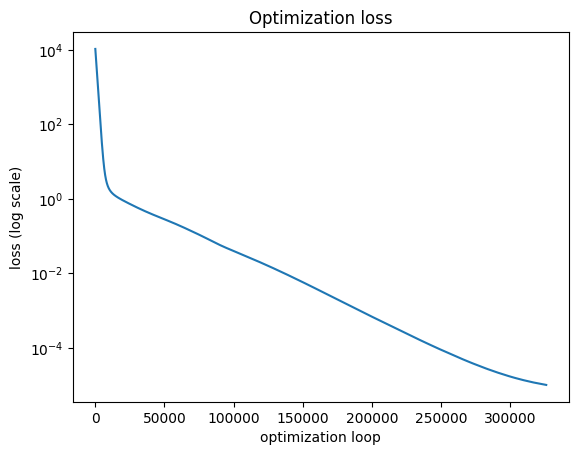

In [93]:
plt.plot(loss_list)
plt.yscale('log')
plt.title('Optimization loss')
plt.xlabel('optimization loop')
plt.ylabel('loss (log scale)')

Text(0.5, 0, 'PC3')

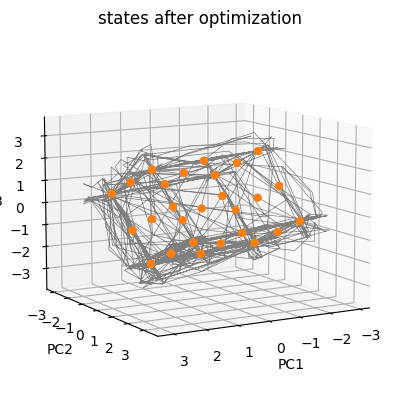

In [106]:
x_pca = pca.transform(states_tensor.detach())
ax = plt.axes(projection='3d')
ax.plot3D(hiddens_pca[:1000, 0], hiddens_pca[:1000, 1], hiddens_pca[:1000, 2], linewidth=0.5, color='gray')
ax.scatter3D(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], color='C1')
ax.view_init(10, 60, 0)
ax.set_title('states after optimization')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


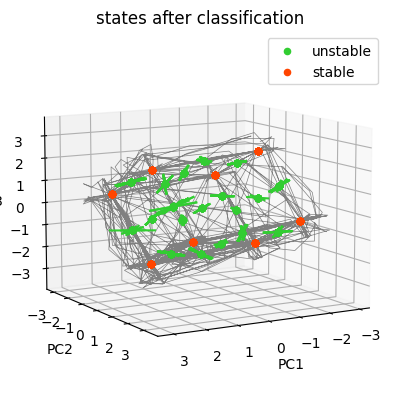

In [107]:
# model.rnn.weight_hh_l0.shape
# f = lambda k: k @ model.rnn.weight_hh_l0
f = lambda k: model.rnn(torch.zeros([1, 1, 3]), k.unsqueeze(dim=0).unsqueeze(dim=0))[1].squeeze(dim=0)

ax = plt.axes(projection='3d')
ax.plot3D(hiddens_pca[:1000, 0], hiddens_pca[:1000, 1], hiddens_pca[:1000, 2], linewidth=0.5, color='gray')

for idx in range(states_tensor.shape[0]):
    # print(x[idx, :])
    eigvals, eigvecs = eig(jacobian(f, states_tensor[idx, :]))
    mag = abs(eigvals[0]) # eigenvalue magnitudes   
    # print(abs(eigvals))
    stableleg = True
    unstableleg = True

    if sum(mag > 1) > 0:
        # continue
        
        if unstableleg:
            uns = ax.scatter3D(x_pca[idx, 0], x_pca[idx, 1], x_pca[idx, 2], color='limegreen')
            # ax.legend('u')
            unstableleg = False
        ax.scatter3D(x_pca[idx, 0], x_pca[idx, 1], x_pca[idx, 2], color='limegreen')
        maxidx = np.argmax(mag)
    
        maxmag = mag[maxidx]
        maxevec = eigvecs[:, maxidx] 
        lineplus = x_pca[idx, :] + pca.transform(np.real(maxevec)*maxmag)
        lineminus = x_pca[idx, :] - pca.transform(np.real(maxevec)*maxmag)
        plot_line = np.vstack((lineminus, x_pca[idx, :], lineplus))
        ax.plot(plot_line[:, 0], plot_line[:, 1], plot_line[:, 2], color='limegreen')
        # break
    else:
        if stableleg:
            sta = ax.scatter3D(x_pca[idx, 0], x_pca[idx, 1], x_pca[idx, 2], color='orangered')
            # ax.legend('s')
            stableleg = False

        ax.scatter3D(x_pca[idx, 0], x_pca[idx, 1], x_pca[idx, 2], color='orangered')

ax.view_init(10, 60, 0)
ax.set_title('states after classification')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend([uns, sta], ['unstable', 'stable'])


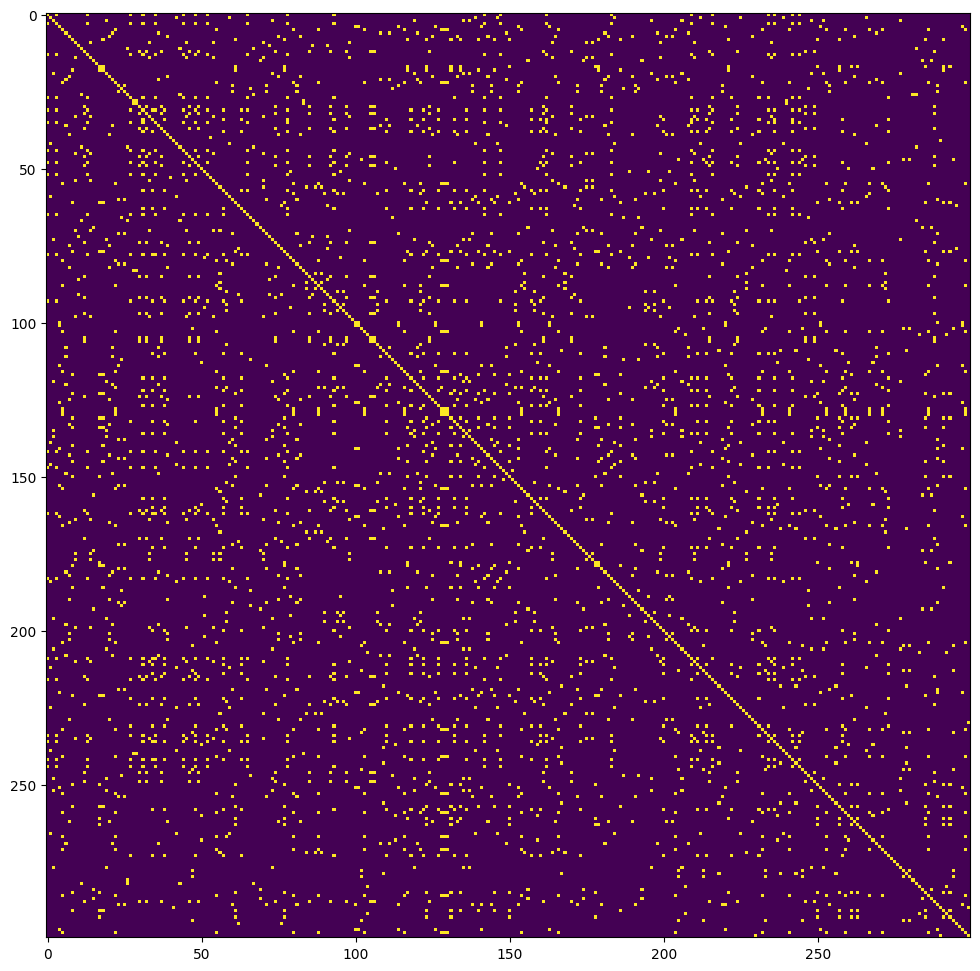

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(pairwise_distances(states_tensor[:300]) < 0.001)

In [30]:
# torch.save(model, './saved_model')
# torch.save(init_states, './saved_is')
# torch.save(states_tensor, './saved_st')

Text(0.5, 0, 'PC3')

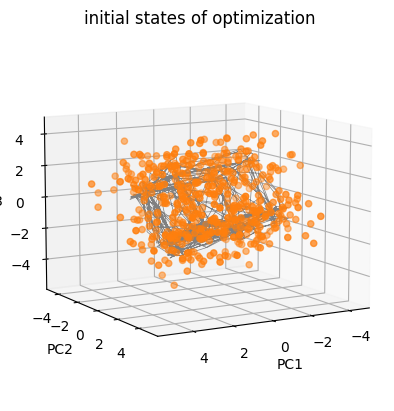

In [98]:
x_pca = pca.transform(init_states.detach())
ax = plt.axes(projection='3d')
ax.plot3D(hiddens_pca[:1000, 0], hiddens_pca[:1000, 1], hiddens_pca[:1000, 2], linewidth=0.5, color='gray')
ax.scatter3D(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], color='C1')
ax.view_init(10, 60, 0)
ax.set_title('initial states of optimization')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')